# Natural Computing - Assignment 3 - Artificial Immune Systems
## Exercise 2 - Intrusion Detection for Unix Processes
#### Submission by group 25 (Chihab Amghane, Max Driessen, Jordy Naus)

This file contains our code for exercise 2 of the "Artificial Immune Systems" assignment of the Natural Computing course.

### Imports

In [1]:
!pip install StringDist

In [2]:
from subprocess import Popen, PIPE, STDOUT
from sklearn.metrics import auc
import matplotlib.pyplot as plt 
import numpy as np
import stringdist
import random

### Determine whether algorithm should run again or use old results (WARNING: running takes > 1h)

In [3]:
RUN_ALGORITHM = False

### Interfacing with the Java implementation of the Negative Selection algorithm

In [4]:
def get_negsel_outputs(test_filename, 
                       train_filename,
                       alphabet_filename,
                       negsel_folder="negative-selection",
                       n=10, r=4, c=True, l=True):
    
    # Make sure that negsel_folder ends in / if it is not empty
    negsel_folder += "/" if not negsel_folder.endswith("/") and negsel_folder else ""
    
    # Create command using given filenames and parameters
    command = f"java -jar {negsel_folder}negsel2.jar " \
              f"-alphabet file://{negsel_folder}{alphabet_filename} " \
              f"-self {negsel_folder}{train_filename} " \
              f"-n {n} -r {r} {'-c' if c else ''} {'-l' if l else ''} " \
              f"< {negsel_folder}{test_filename}"
    
    # Run the command
    process = Popen(command, stdout=PIPE, shell=True, stderr=STDOUT, bufsize=-1, close_fds=True)
    
    # Extract and return output values (if multiple values are returned for one line, use the average)
    outputs = []
    for line in iter(process.stdout.readline, b''):
        values = [float(val) for val in line.rstrip().decode('utf-8').split(" ")]
        outputs.append(np.average(values) if values[0] == values[0] else 0.0)
    return outputs

### Preprocessing

#### Utility functions

In [5]:
def write_to_file(data, folder_name, filename):
    
    # Make sure that negsel_folder ends in / if it is not empty
    folder_name += "/" if not folder_name.endswith("/") and folder_name else ""
    
    # Write the provided data to the specified file, one line at a time
    with open(f"{folder_name}{filename}", "w") as f:
        for line in data:
            f.write(f"{line}\n")

In [6]:
def remove_similar(data, min_dist):
    """ Removing datapoints that are too similar (Levenshtein distance < min_dist) """
    
    # Iterate through data, only adding datapoint to new_data that are not too similar to the ones already in new_data
    new_data = []
    for datapoint in data:
        if not any([stringdist.levenshtein(datapoint, x) < min_dist for x in new_data]):
            new_data.append(datapoint)
    
    # Return new_data (in which all datapoints have a Levenshtein distance of at least min_dist)
    return new_data

#### Training data (chunking)

In [7]:
def preprocess_train(folder_name, data_type, n, max_size=float('inf'), init_only=False):
    """ Preprocessing function for the training data (chunking, removing duplicates & chunks that are too similar) """
    
    # Make sure that folder_name ends in / if it is not empty
    folder_name += "/" if not folder_name.endswith("/") and folder_name else ""
    
    # Extract train data
    with open(f"{folder_name}{data_type}.train", "r") as f:
        data = [line.rstrip() for line in f.readlines()]
    
    # Split data into equally-sized chunks
    chunked_data = []
    for line in data:
        chunked_data.extend([line[:n]] if init_only else [line[i:i+n] for i in range(len(line)-n+1)])
        
    # Remove duplicates
    chunked_data = list(set(chunked_data))
    
    # Take random sample if size exceeds max_size
    if len(chunked_data) > max_size:
        chunked_data = random.sample(chunked_data, max_size)
    
    # Return the chunked training data
    return chunked_data

##### Full training set

In [8]:
cert_chunked_train_full = preprocess_train("negative-selection/syscalls/snd-cert", "snd-cert", 7)
unm_chunked_train_full = preprocess_train("negative-selection/syscalls/snd-unm", "snd-unm", 7)

In [9]:
write_to_file(cert_chunked_train_full, "negative-selection/syscalls/snd-cert", "snd-cert.chunked_full.train")
write_to_file(unm_chunked_train_full, "negative-selection/syscalls/snd-unm", "snd-unm.chunked_full.train")

##### Small training set

In [10]:
cert_chunked_train_small = preprocess_train("negative-selection/syscalls/snd-cert", "snd-cert", 7, 50)
unm_chunked_train_small = preprocess_train("negative-selection/syscalls/snd-unm", "snd-unm", 7, 50)

In [11]:
write_to_file(cert_chunked_train_small, "negative-selection/syscalls/snd-cert", "snd-cert.chunked_small.train")
write_to_file(unm_chunked_train_small, "negative-selection/syscalls/snd-unm", "snd-unm.chunked_small.train")

##### Init training set (first chunk only)

In [12]:
cert_chunked_train_init = preprocess_train("negative-selection/syscalls/snd-cert", "snd-cert", 7, init_only=True)
unm_chunked_train_init = preprocess_train("negative-selection/syscalls/snd-unm", "snd-unm", 7, init_only=True)

In [13]:
write_to_file(cert_chunked_train_init, "negative-selection/syscalls/snd-cert", "snd-cert.chunked_init.train")
write_to_file(unm_chunked_train_init, "negative-selection/syscalls/snd-unm", "snd-unm.chunked_init.train")

#### Test data (split into self and foreign)

In [14]:
def extract_self_foreign(folder_name, data_type, parts=[1,2,3]):
    
    # Make sure that folder_name ends in / if it is not empty
    folder_name += "/" if not folder_name.endswith("/") and folder_name else ""
    
    # Extract data from the desired parts
    data, labels = [], []
    for part in parts:
        # Set the correct file location
        loc = f"{folder_name}{data_type}.{part}"
        
        # Extract the test data of this part
        with open(f"{loc}.test", "r") as f:
            data.extend([line.rstrip() for line in f.readlines()])
        
        # Extract the labels of this part
        with open(f"{loc}.labels", "r") as f:
            labels.extend([int(line.rstrip()) for line in f.readlines()])
            
    # Convert test data and labels to np arrays
    data = np.array(data)
    labels = np.array(labels)
    
    # Extract self and foreign test data
    self = data[labels == 0].tolist()
    foreign = data[labels == 1].tolist()
    
    # Return self and foreign test data
    return self, foreign

##### Full test sets

In [15]:
cert_self_full, cert_foreign_full = extract_self_foreign("negative-selection/syscalls/snd-cert", "snd-cert", [1,2,3])
unm_self_full, unm_foreign_full = extract_self_foreign("negative-selection/syscalls/snd-unm", "snd-unm", [1,2,3])

In [16]:
write_to_file(cert_self_full, "negative-selection/syscalls/snd-cert", "snd-cert.self_full.test")
write_to_file(cert_foreign_full, "negative-selection/syscalls/snd-cert", "snd-cert.foreign_full.test")
write_to_file(unm_self_full, "negative-selection/syscalls/snd-unm", "snd-unm.self_full.test")
write_to_file(unm_foreign_full, "negative-selection/syscalls/snd-unm", "snd-unm.foreign_full.test")

##### Small test sets

In [17]:
cert_self_small, cert_foreign_small = extract_self_foreign("negative-selection/syscalls/snd-cert", "snd-cert", [1])
unm_self_small, unm_foreign_small = extract_self_foreign("negative-selection/syscalls/snd-unm", "snd-unm", [1])

In [18]:
write_to_file(cert_self_small, "negative-selection/syscalls/snd-cert", "snd-cert.self_small.test")
write_to_file(cert_foreign_small, "negative-selection/syscalls/snd-cert", "snd-cert.foreign_small.test")
write_to_file(unm_self_small, "negative-selection/syscalls/snd-unm", "snd-unm.self_small.test")
write_to_file(unm_foreign_small, "negative-selection/syscalls/snd-unm", "snd-unm.foreign_small.test")

### Computing ROC-AUC

In [19]:
def roc_auc(self_outputs, foreign_outputs, title="ROC Curve"):
    # Initialize lists for True Positive Rate (sensitivity) and True Negative Rate (specificity) values
    TPRs, FPRs = [], []
    
    # Merge outputs
    merged_outputs = self_outputs + foreign_outputs
    cut_off_scores = sorted(set(merged_outputs))

    # Compute sensitivity and specificity for each cut-off score in the merged outputs
    for cut_off_score in cut_off_scores:
        # Calculate TPR/sensitivity: TP/(TP+FN) (% of "foreign_outputs" > cut-off score)
        TPRs.append(sum(np.array(foreign_outputs) > cut_off_score) / len(foreign_outputs))

        # Calculate TNR/specificity: TN/(TN+FP) ($% of "self_outputs" < cut-off score)
        FPRs.append(1 - sum(np.array(self_outputs) < cut_off_score) / len(self_outputs))
    
    # Plot ROC curve
    plt.plot(FPRs, TPRs)
    plt.plot([0.0, 1.0], [0.0, 1.0], ls='--')
    plt.xlabel('False Positive Rate (1-specificity)')
    plt.ylabel('True Positive Rate (sensitivity)')
    plt.title(title)
    plt.show()
    
    # Compute and print AUC score (AUC is computed using FPRs and TPRs)
    print(f"ROC-AUC score = {auc(FPRs, TPRs)}")

### Running the algorithm

#### Full training dataset, small testing dataset

##### snd-cert

In [20]:
if RUN_ALGORITHM:
    # Get the output of the negative selection algorithm on the snd-cert testing sets using the full training set
    cert_self_full_outputs = get_negsel_outputs("syscalls/snd-cert/snd-cert.self_small.test", 
                                                "syscalls/snd-cert/snd-cert.chunked_full.train", 
                                                "syscalls/snd-cert/snd-cert.alpha",
                                                n=7, r=4)
    cert_foreign_full_outputs = get_negsel_outputs("syscalls/snd-cert/snd-cert.foreign_small.test", 
                                                   "syscalls/snd-cert/snd-cert.chunked_full.train", 
                                                   "syscalls/snd-cert/snd-cert.alpha",
                                                   n=7, r=4)

In [21]:
if RUN_ALGORITHM:
    # Write results to file (since running the above cell takes a long time)
    write_to_file(cert_self_full_outputs, "outputs", "cert_self_full.outputs")
    write_to_file(cert_foreign_full_outputs, "outputs", "cert_foreign_full.outputs")

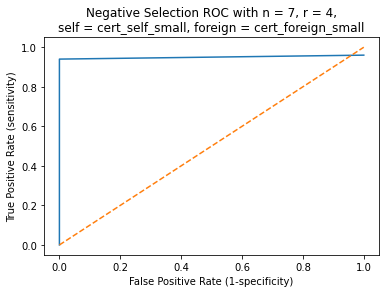

ROC-AUC score = 0.95


In [22]:
# Reload data if required
if not RUN_ALGORITHM:
    with open(f"outputs/cert_self_full.outputs", "r") as f:
        cert_self_full_outputs = [float(line.rstrip()) for line in f.readlines()]
    with open(f"outputs/cert_foreign_full.outputs", "r") as f:
        cert_foreign_full_outputs = [float(line.rstrip()) for line in f.readlines()]

# Compute and show ROC-AUC
roc_auc(cert_self_full_outputs, 
        cert_foreign_full_outputs, 
        "Negative Selection ROC with n = 7, r = 4,\nself = cert_self_small, foreign = cert_foreign_small")

##### snd-unm

In [23]:
if RUN_ALGORITHM:
    # Get the output of the negative selection algorithm on the snd-unm testing sets using the full training set
    unm_self_full_outputs = get_negsel_outputs("syscalls/snd-unm/snd-unm.self_small.test", 
                                               "syscalls/snd-unm/snd-unm.chunked_full.train", 
                                               "syscalls/snd-unm/snd-unm.alpha",
                                               n=7, r=4)
    unm_foreign_full_outputs = get_negsel_outputs("syscalls/snd-unm/snd-unm.foreign_small.test", 
                                                  "syscalls/snd-unm/snd-unm.chunked_full.train", 
                                                  "syscalls/snd-unm/snd-unm.alpha",
                                                  n=7, r=4)

In [24]:
if RUN_ALGORITHM:
    # Write results to file (since running the above cell takes a long time)
    write_to_file(unm_self_full_outputs, "outputs", "unm_self_full.outputs")
    write_to_file(unm_foreign_full_outputs, "outputs", "unm_foreign_full.outputs")

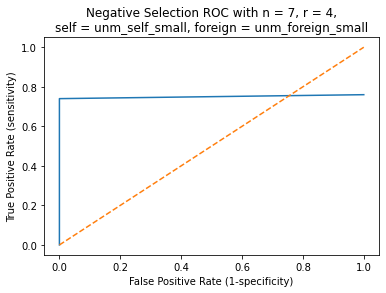

ROC-AUC score = 0.75


In [25]:
# Compute and show ROC-AUC
if not RUN_ALGORITHM:
    with open(f"outputs/unm_self_full.outputs", "r") as f:
        unm_self_full_outputs = [float(line.rstrip()) for line in f.readlines()]
    with open(f"outputs/unm_foreign_full.outputs", "r") as f:
        unm_foreign_full_outputs = [float(line.rstrip()) for line in f.readlines()]

# Reload data if required
roc_auc(unm_self_full_outputs, 
        unm_foreign_full_outputs, 
        "Negative Selection ROC with n = 7, r = 4,\nself = unm_self_small, foreign = unm_foreign_small")

#### Small training dataset, full testing dataset

##### snd-cert

In [26]:
if RUN_ALGORITHM:
    # Get the output of the negative selection algorithm on the snd-cert testing sets using the small training set
    cert_self_small_outputs = get_negsel_outputs("syscalls/snd-cert/snd-cert.self_full.test", 
                                                 "syscalls/snd-cert/snd-cert.chunked_small.train", 
                                                 "syscalls/snd-cert/snd-cert.alpha",
                                                 n=7, r=4)
    cert_foreign_small_outputs = get_negsel_outputs("syscalls/snd-cert/snd-cert.foreign_full.test", 
                                                    "syscalls/snd-cert/snd-cert.chunked_small.train", 
                                                    "syscalls/snd-cert/snd-cert.alpha",
                                                    n=7, r=4)

In [27]:
if RUN_ALGORITHM:
    # Write results to file (since running the above cell takes a long time)
    write_to_file(cert_self_small_outputs, "outputs", "cert_self_small.outputs")
    write_to_file(cert_foreign_small_outputs, "outputs", "cert_foreign_small.outputs")

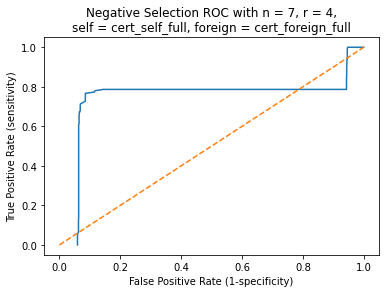

ROC-AUC score = 0.7466709677419354


In [28]:
# Reload data if required
if not RUN_ALGORITHM:
    with open(f"outputs/cert_self_small.outputs", "r") as f:
        cert_self_small_outputs = [float(line.rstrip()) for line in f.readlines()]
    with open(f"outputs/cert_foreign_small.outputs", "r") as f:
        cert_foreign_small_outputs = [float(line.rstrip()) for line in f.readlines()]

# Compute and show ROC-AUC
roc_auc(cert_self_small_outputs, 
        cert_foreign_small_outputs, 
        "Negative Selection ROC with n = 7, r = 4,\nself = cert_self_full, foreign = cert_foreign_full")

##### snd-unm

In [29]:
if RUN_ALGORITHM:
    # Get the output of the negative selection algorithm on the snd-unm testing sets using the small training set
    unm_self_small_outputs = get_negsel_outputs("syscalls/snd-unm/snd-unm.self_full.test", 
                                                "syscalls/snd-unm/snd-unm.chunked_small.train", 
                                                "syscalls/snd-unm/snd-unm.alpha",
                                                n=7, r=4)
    unm_foreign_small_outputs = get_negsel_outputs("syscalls/snd-unm/snd-unm.foreign_full.test", 
                                                   "syscalls/snd-unm/snd-unm.chunked_small.train", 
                                                   "syscalls/snd-unm/snd-unm.alpha",
                                                   n=7, r=4)

In [30]:
if RUN_ALGORITHM:
    # Write results to file (since running the above cell takes a long time)
    write_to_file(unm_self_small_outputs, "outputs", "unm_self_small.outputs")
    write_to_file(unm_foreign_small_outputs, "outputs", "unm_foreign_small.outputs")

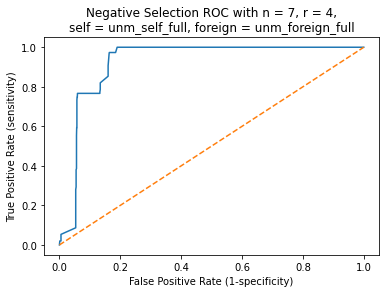

ROC-AUC score = 0.9246903225806452


In [31]:
# Reload data if required
if not RUN_ALGORITHM:
    with open(f"outputs/unm_self_small.outputs", "r") as f:
        unm_self_small_outputs = [float(line.rstrip()) for line in f.readlines()]
    with open(f"outputs/unm_foreign_small.outputs", "r") as f:
        unm_foreign_small_outputs = [float(line.rstrip()) for line in f.readlines()]

        # Compute and show ROC-AUC
roc_auc(unm_self_small_outputs, 
        unm_foreign_small_outputs, 
        "Negative Selection ROC with n = 7, r = 4,\nself = unm_self_full, foreign = unm_foreign_full")

#### Init training dataset (first chunk only), full testing dataset

##### snd-cert

In [32]:
if RUN_ALGORITHM:
    # Get the output of the negative selection algorithm on the snd-cert testing sets using the init training set
    cert_self_init_outputs = get_negsel_outputs("syscalls/snd-cert/snd-cert.self_full.test", 
                                                "syscalls/snd-cert/snd-cert.chunked_init.train", 
                                                "syscalls/snd-cert/snd-cert.alpha",
                                                n=7, r=4)
    cert_foreign_init_outputs = get_negsel_outputs("syscalls/snd-cert/snd-cert.foreign_full.test", 
                                                   "syscalls/snd-cert/snd-cert.chunked_init.train", 
                                                   "syscalls/snd-cert/snd-cert.alpha",
                                                   n=7, r=4)

In [33]:
if RUN_ALGORITHM:
    # Write results to file (since running the above cell takes a long time)
    write_to_file(cert_self_init_outputs, "outputs", "cert_self_init.outputs")
    write_to_file(cert_foreign_init_outputs, "outputs", "cert_foreign_init.outputs")

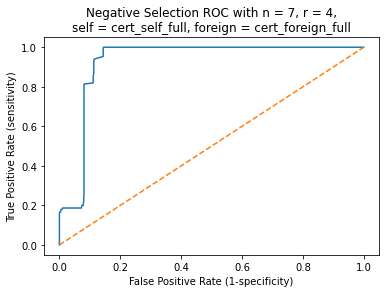

ROC-AUC score = 0.9269354838709677


In [34]:
# Reload data if required
if not RUN_ALGORITHM:
    with open(f"outputs/cert_self_init.outputs", "r") as f:
        cert_self_init_outputs = [float(line.rstrip()) for line in f.readlines()]
    with open(f"outputs/cert_foreign_init.outputs", "r") as f:
        cert_foreign_init_outputs = [float(line.rstrip()) for line in f.readlines()]

# Compute and show ROC-AUC
roc_auc(cert_self_init_outputs, 
        cert_foreign_init_outputs, 
        "Negative Selection ROC with n = 7, r = 4,\nself = cert_self_full, foreign = cert_foreign_full")

##### snd-unm

In [35]:
if RUN_ALGORITHM:
    # Get the output of the negative selection algorithm on the snd-unm testing sets using the init training set
    unm_self_init_outputs = get_negsel_outputs("syscalls/snd-unm/snd-unm.self_full.test", 
                                               "syscalls/snd-unm/snd-unm.chunked_init.train", 
                                               "syscalls/snd-unm/snd-unm.alpha",
                                               n=7, r=4)
    unm_foreign_init_outputs = get_negsel_outputs("syscalls/snd-unm/snd-unm.foreign_full.test", 
                                                  "syscalls/snd-unm/snd-unm.chunked_init.train", 
                                                  "syscalls/snd-unm/snd-unm.alpha",
                                                  n=7, r=4)

In [36]:
if RUN_ALGORITHM:
    # Write results to file (since running the above cell takes a long time)
    write_to_file(unm_self_init_outputs, "outputs", "unm_self_init.outputs")
    write_to_file(unm_foreign_init_outputs, "outputs", "unm_foreign_init.outputs")

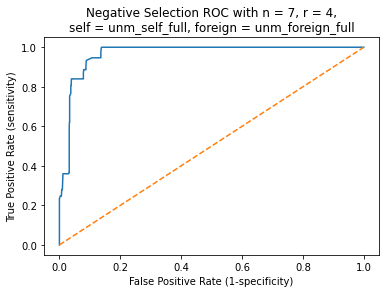

ROC-AUC score = 0.9664172043010754


In [37]:
# Reload data if required
if not RUN_ALGORITHM:
    with open(f"outputs/unm_self_init.outputs", "r") as f:
        unm_self_init_outputs = [float(line.rstrip()) for line in f.readlines()]
    with open(f"outputs/unm_foreign_init.outputs", "r") as f:
        unm_foreign_init_outputs = [float(line.rstrip()) for line in f.readlines()]

# Compute and show ROC-AUC
roc_auc(unm_self_init_outputs, 
        unm_foreign_init_outputs, 
        "Negative Selection ROC with n = 7, r = 4,\nself = unm_self_full, foreign = unm_foreign_full")